# **Census Income**

## Download data

In [1]:
import requests
import os

# Link: https://archive.ics.uci.edu/ml/datasets/Census+Income
dataset_url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_url2 = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
filename1 = "adult_data.csv"
filename2 = "adult_test.csv"

if not filename1 in os.listdir():
  response = requests.get(dataset_url1)
  with open(filename1, 'wb') as file:
    file.write(response.content)
  print(filename1 + " downloaded")
else:
  print(filename1 + " already exist")

if not filename2 in os.listdir():
  response = requests.get(dataset_url2)
  with open(filename2, 'wb') as file:
    file.write(response.content)
  print(filename2 + " downloaded")
else:
  print(filename2 + " already exist")

adult_data.csv downloaded
adult_test.csv downloaded


## Create dataframe

In [2]:
import pandas as pd
import numpy as np

columns_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]

df1 = pd.read_csv(filename1, header=0, skip_blank_lines=True, names=columns_names)
df2 = pd.read_csv(filename2, header=0, skip_blank_lines=True, names=columns_names)
df = pd.concat([df1, df2])

df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


## Replace missing data

In [3]:
def df_replace_nan():
  for (col_name, col) in df.iteritems():
    if '?' in list(col):
      numeric = pd.to_numeric(df[col_name], errors='coerce')
      mean_val = np.mean(numeric)
      if not np.isnan(mean_val):
        df[col_name] = numeric
        df[col_name].replace(np.nan, mean_val, inplace=True)
      df[col_name].replace('?', mean_val, inplace=True)
  df.fillna(df.mode().iloc[0], inplace=True)

def arr_replace_nan():
  for col_name in arr.dtype.names:
    col = arr[col_name]
    if '?' in col:
      numeric = pd.to_numeric(col, errors='coerce')
      mean_val = np.nanmean(numeric)
      if np.isnan(mean_val):
        unique, pos = np.unique(col, return_inverse=True)
        counts = np.bincount(pos)
        maxpos = counts.argmax()
        mean_val = unique[maxpos]
        arr[col_name] = np.where(col=='?', mean_val, col)
      else:
        arr[col_name] = numeric
        arr[col_name].astype(np.float, copy=False)
        arr[col_name] = np.where(col==np.nan, mean_val, col)

%timeit df_replace_nan()
# %timeit arr_replace_nan()
arr = df.to_numpy()

df.head()

1 loop, best of 3: 128 ms per loop


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


## Balance data

In [4]:
from sklearn.utils import resample

print(df['salary'].value_counts())

df['salary'] = df['salary'].str.replace('.', '')
print(df['salary'].value_counts())

df_majority = df[df['salary'] == '<=50K']
df_minority = df[df['salary'] == '>50K']

df_majority_downsampled = resample(df_majority, 
                                 replace=False, 
                                 n_samples=11687, 
                                 random_state=123)

df = pd.concat([df_majority_downsampled, df_minority])

print(df['salary'].value_counts())

<=50K     24719
<=50K.    12435
>50K       7841
>50K.      3846
Name: salary, dtype: int64
<=50K    37154
>50K     11687
Name: salary, dtype: int64
<=50K    11687
>50K     11687
Name: salary, dtype: int64


## Norm / Standart / Onehot data

In [5]:
norm_map = {
    'age': 'standartization', 'workclass': 'onehot', 'fnlwgt': 'normalization', 'education': 'onehot', 
    'education-num': 'standartization', 'marital-status': 'onehot', 'occupation': 'onehot', 'relationship': 'onehot', 
    'race': 'onehot', 'sex': 'onehot', 'capital-gain': 'normalization', 'capital-loss': 'normalization', 
    'hours-per-week': 'standartization', 'native-country': 'onehot', 'salary': 'onehot'
}

def df_norm_standart_onehot(dataframe):
  result = dataframe.copy()
  for feature_name in dataframe.columns:
    if norm_map[feature_name] == "normalization":
      max_value = dataframe[feature_name].max()
      min_value = dataframe[feature_name].min()
      result[feature_name] = (dataframe[feature_name] - min_value) / (max_value - min_value)
    if norm_map[feature_name] == "standartization":
      mean_value = dataframe[feature_name].mean()
      std_value = dataframe[feature_name].std()
      result[feature_name] = (dataframe[feature_name] - mean_value) / std_value
    if norm_map[feature_name] == "onehot":
      dummies = pd.get_dummies(dataframe[[feature_name]])
      result = pd.concat([result, dummies], axis=1)
      result = result.drop([feature_name], axis=1)
  return result

def arr_norm_standart_onehot(array):
  result = np.copy(array)
  for i, feature_name in enumerate(norm_map.keys()):
    if norm_map[feature_name] == "normalization":
      max_value = array[:, i].max()
      min_value = array[:, i].min()
      result[:, i] = (array[:, i] - min_value) / (max_value - min_value)
    if norm_map[feature_name] == "standartization":
      mean_value = array[:, i].mean()
      std_value = array[:, i].std()
      result[:, i] = (array[:, i] - mean_value) / std_value
    if norm_map[feature_name] == "onehot":
      dummies = pd.get_dummies(array[:, i]).to_numpy()
      result = np.hstack((result, dummies))
      # result = result.drop([feature_name], axis=1)
      # np.delete(e, [1,3], axis=1)
  return result

%timeit df_norm_standart_onehot(df)
%timeit arr_norm_standart_onehot(arr)

norm_df = df_norm_standart_onehot(df)
norm_arr = norm_df.to_numpy()

norm_df.head()

1 loop, best of 3: 203 ms per loop
1 loop, best of 3: 380 ms per loop


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,...,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary_<=50K,salary_>50K
18927,-1.198422,0.122677,-0.228604,0.0,0.000000,-0.173994,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
19509,1.105145,0.191090,-0.228604,0.0,0.000000,-0.173994,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4584,-1.044851,0.016175,0.535774,0.0,0.000000,-0.173994,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
23885,-1.044851,0.195628,-0.228604,0.0,0.000000,-0.173994,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
10262,0.260504,0.237197,-0.228604,0.0,0.454545,0.234431,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Show histograms

age


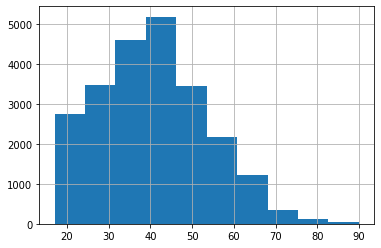

workclass


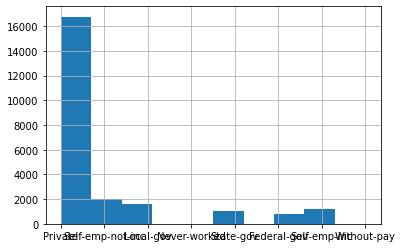

fnlwgt


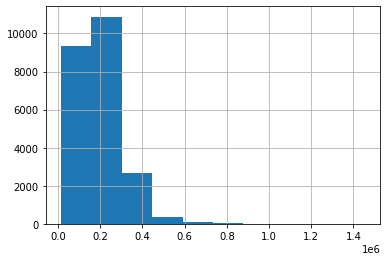

education


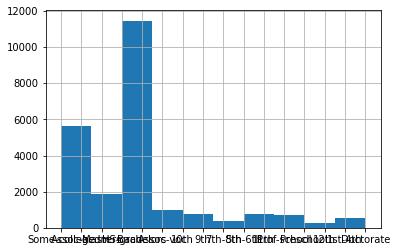

education-num


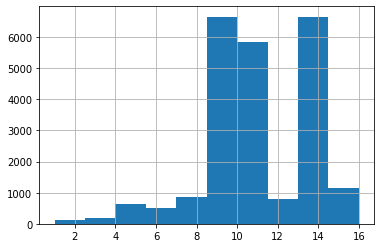

marital-status


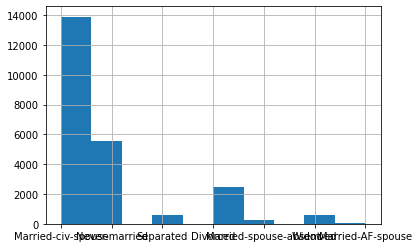

occupation


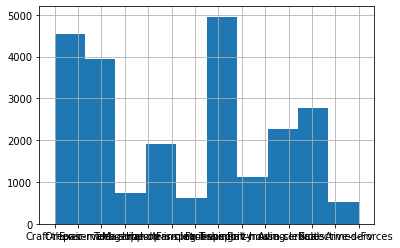

relationship


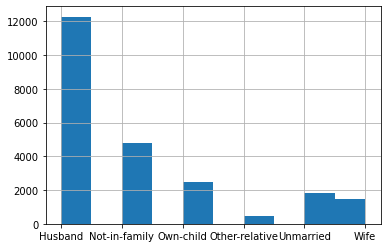

race


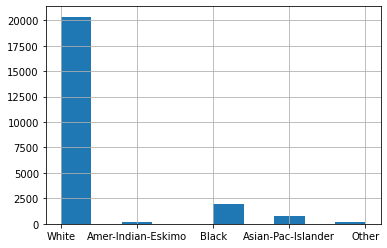

sex


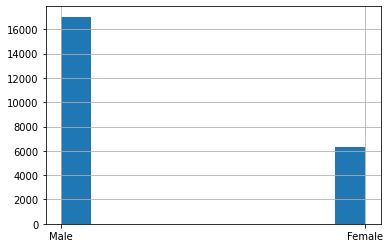

capital-gain


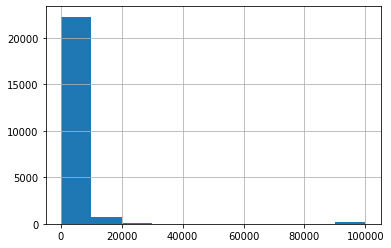

capital-loss


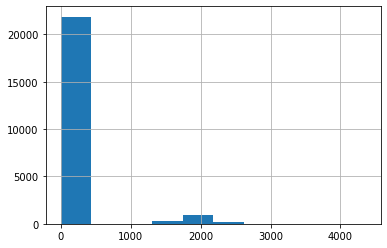

hours-per-week


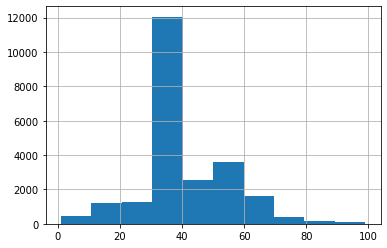

native-country


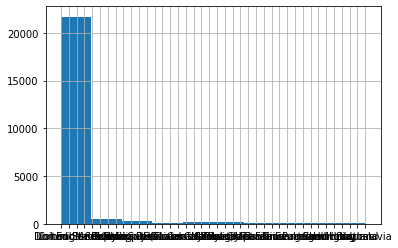

salary


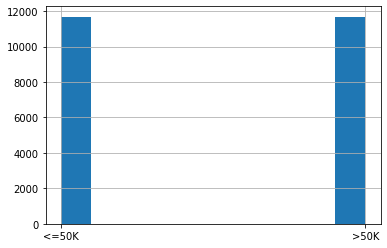

In [6]:
import matplotlib.pyplot as plt

for col_name in df.columns.values:
  print(col_name)
  df[col_name].hist()
  plt.show()

## Show how two columns depend on each other

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


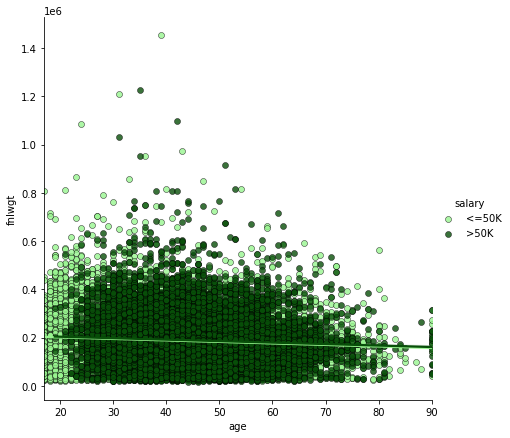

In [7]:
import seaborn as sns

green_palette = {"<=50K": "#99f590", ">50K": "#084f09"}
lp = sns.lmplot(x='age', y='fnlwgt', hue='salary', 
                palette=green_palette, size=6,
                data=df, fit_reg=True, legend=True,
                scatter_kws=dict(edgecolor="k", linewidth=0.5))

# plt.show()
# plt.scatter(arr[:, -1], arr[:, 16])
# plt.show()

## Show correlations

In [8]:
%timeit df.corr(method='pearson')
%timeit np.corrcoef(norm_arr)

corr = df.corr(method='pearson')
corr

The slowest run took 6.04 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.18 ms per loop
1 loop, best of 3: 6.88 s per loop


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.073303,0.071223,0.085735,0.054867,0.055545
fnlwgt,-0.073303,1.000000,-0.030825,-0.003948,0.000336,-0.008162
education-num,0.071223,-0.030825,1.000000,0.142641,0.096364,0.163280
capital-gain,0.085735,-0.003948,0.142641,1.000000,-0.050889,0.093540
capital-loss,0.054867,0.000336,0.096364,-0.050889,1.000000,0.058534
hours-per-week,0.055545,-0.008162,0.163280,0.093540,0.058534,1.000000


In [9]:
df.corr(method='spearman')

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.074549,0.096535,0.132387,0.055919,0.104651
fnlwgt,-0.074549,1.000000,-0.025041,-0.004461,0.003779,-0.010072
education-num,0.096535,-0.025041,1.000000,0.153775,0.092477,0.198089
capital-gain,0.132387,-0.004461,0.153775,1.000000,-0.099484,0.106028
capital-loss,0.055919,0.003779,0.092477,-0.099484,1.000000,0.067050
hours-per-week,0.104651,-0.010072,0.198089,0.106028,0.067050,1.000000


## Visualization

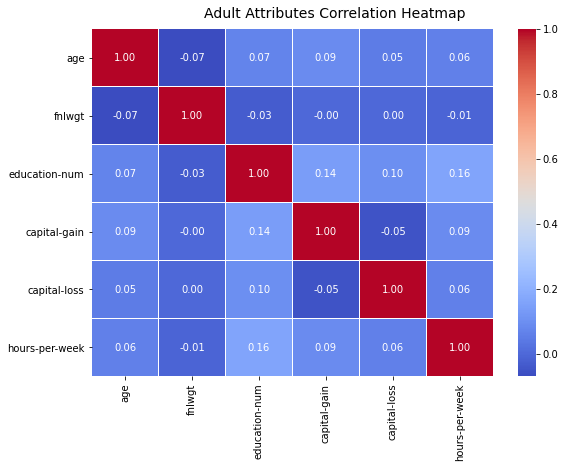

In [10]:
f, ax = plt.subplots(figsize=(9, 6))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Adult Attributes Correlation Heatmap', fontsize=14)

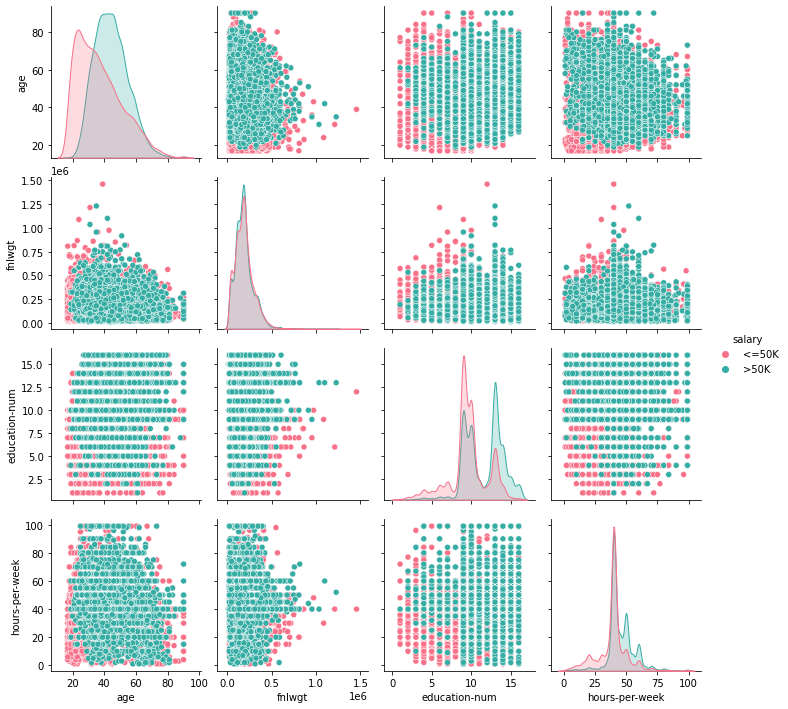

In [11]:
sns.pairplot(df, hue='salary', vars=['age', 'fnlwgt', 'education-num', 'hours-per-week'], palette='husl')

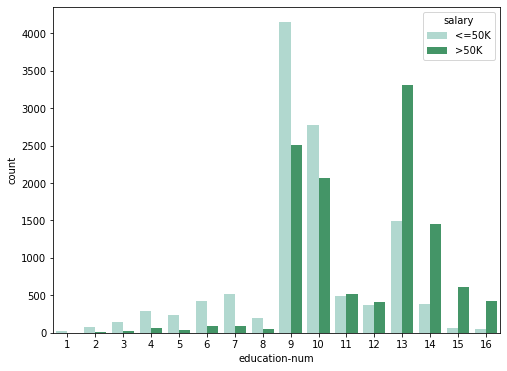

In [12]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
cp = sns.countplot(x="education-num", hue="salary", data=df, 
                   palette='BuGn', ax=ax)

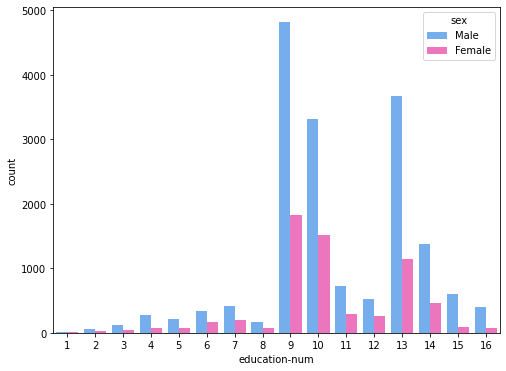

In [13]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
sex_palette = {"Male": "#63acff", "Female": "#ff63c3"}
cp = sns.countplot(x="education-num", hue="sex", data=df, 
                   palette=sex_palette, ax=ax)

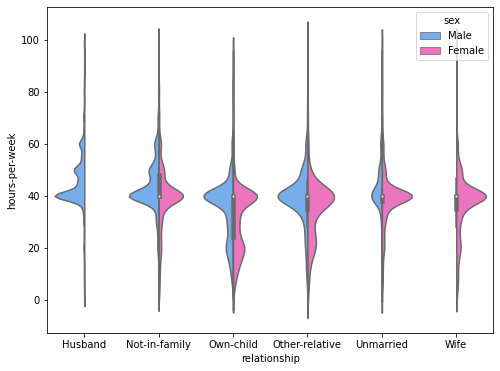

In [14]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
vp = sns.violinplot(x="relationship", y="hours-per-week", hue="sex",
                    data=df, palette=sex_palette, split=True,
                    scale="count", ax=ax)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


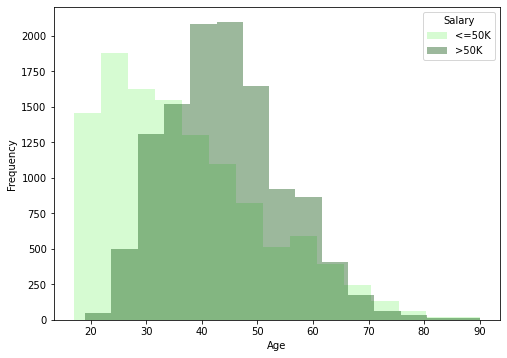

In [15]:
fig = plt.figure(figsize = (8, 6))
fig.subplots_adjust(top=0.85, wspace=0.3)
ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")

g = sns.FacetGrid(df, hue='salary', palette=green_palette)
g.map(sns.distplot, 'age', kde=False, bins=15, ax=ax)
ax.legend(title='Salary')
plt.close(2)

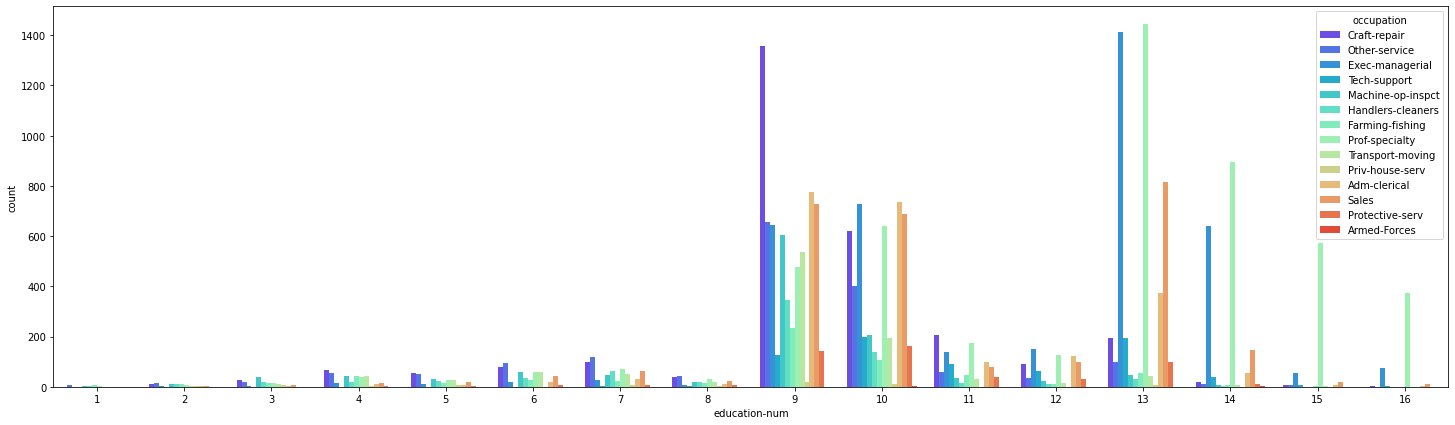

In [16]:
fig = plt.figure(figsize = (25, 7))
ax = fig.add_subplot(1, 1, 1)
cp = sns.countplot(x="education-num", hue="occupation", data=df, 
                   palette='rainbow', ax=ax)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]), <a list of 72 Text major ticklabel objects>)

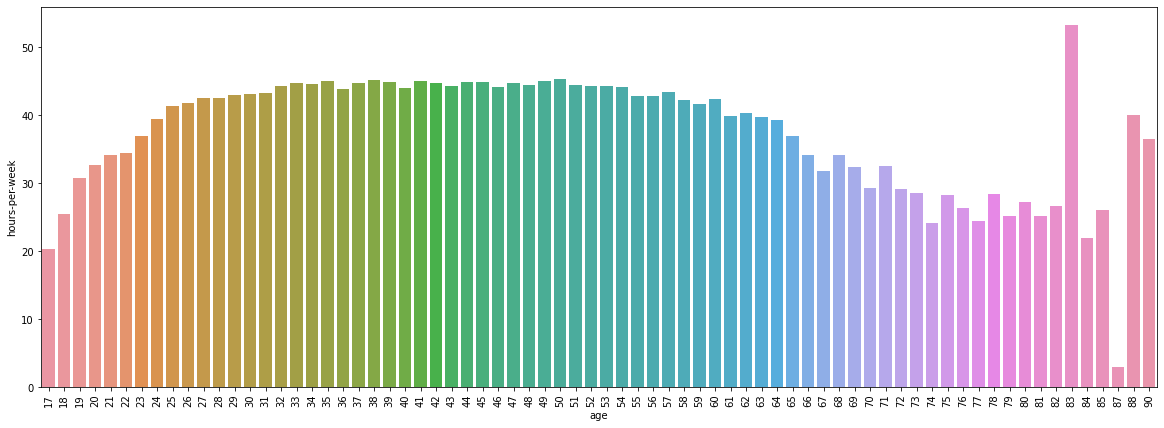

In [17]:
plt.figure(figsize=(20, 7))
sns.barplot(df['age'], df['hours-per-week'], ci=None)
plt.xticks(rotation=90)

Text(0.5, 0, 'Education num')

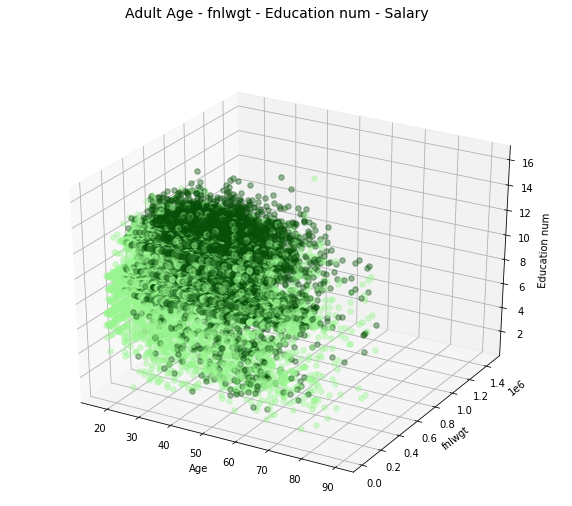

In [18]:
fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('Adult Age - fnlwgt - Education num - Salary', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df['age'])
ys = list(df['fnlwgt'])
zs = list(df['education-num'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = [green_palette[wt] for wt in list(df['salary'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, depthshade=False, s=30)

ax.set_xlabel('Age')
ax.set_ylabel('fnlwgt')
ax.set_zlabel('Education num')

Text(0.5, 0, 'Education num')

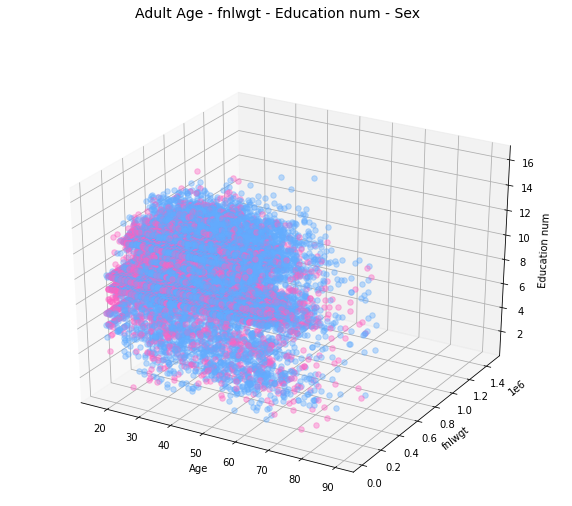

In [19]:
fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('Adult Age - fnlwgt - Education num - Sex', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df['age'])
ys = list(df['fnlwgt'])
zs = list(df['education-num'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = [sex_palette[wt] for wt in list(df['sex'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, depthshade=False, s=30)

ax.set_xlabel('Age')
ax.set_ylabel('fnlwgt')
ax.set_zlabel('Education num')

## Train, Val, and Test data

In [20]:
from sklearn.model_selection import train_test_split

s_names = ['salary_<=50K',	'salary_>50K']

X = norm_df.drop(s_names, 1).to_numpy()
Y = norm_df[s_names].to_numpy()
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)
print("Training X shape: " + str(x_train.shape))
print("Training Y shape: " + str(y_train.shape))
print("Test X shape: " + str(x_test.shape))
print("Test Y shape: " + str(y_test.shape))

X shape: (23374, 104)
Y shape: (23374, 2)
Training X shape: (15193, 104)
Training Y shape: (15193, 2)
Test X shape: (8181, 104)
Test Y shape: (8181, 2)


## Create models

In [21]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# kNN
knn = KNeighborsClassifier()
knn_model = MultiOutputClassifier(estimator=knn)

# Naive Bayes
nb = GaussianNB()
nb_model = MultiOutputClassifier(estimator=nb)

# SVM
svm = SVC(kernel='rbf', C=1e3, gamma=0.1)
svm_model = MultiOutputClassifier(estimator=svm)

# DecisionTree
dtree = DecisionTreeClassifier()
dtree_model = MultiOutputClassifier(estimator=dtree)

# RF
rf = RandomForestClassifier(n_estimators=10)
rf_model = MultiOutputClassifier(estimator=rf)

# MLP
x_shape, y_shape = X.shape[1], Y.shape[1]
mean_shape = (x_shape + y_shape) // 2

mlp_model = Sequential()
mlp_model.add(Dense(x_shape, input_shape=(x_shape,), activation='relu'))
mlp_model.add(Dense(mean_shape, activation='relu'))
mlp_model.add(Dense(y_shape, activation='softmax'))
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               10920     
_________________________________________________________________
dense_1 (Dense)              (None, 53)                5565      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 108       
Total params: 16,593
Trainable params: 16,593
Non-trainable params: 0
_________________________________________________________________



## Fit models

In [22]:
# kNN
knn_model.fit(x_train, y_train)

# Naive Bayes
nb_model.fit(x_train, y_train)

# SVM
svm_model.fit(x_train, y_train)

# DecisionTree
dtree_model.fit(x_train, y_train)

# RF
rf_model.fit(x_train, y_train)

# MLP
history = mlp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10000, callbacks=[es], batch_size=1, verbose=2)

Epoch 1/10000
15193/15193 - 21s - loss: 0.4178 - accuracy: 0.8054 - val_loss: 0.3969 - val_accuracy: 0.8242
Epoch 2/10000
15193/15193 - 21s - loss: 0.3896 - accuracy: 0.8195 - val_loss: 0.3911 - val_accuracy: 0.8187
Epoch 3/10000
15193/15193 - 21s - loss: 0.3787 - accuracy: 0.8236 - val_loss: 0.3873 - val_accuracy: 0.8214
Epoch 4/10000
15193/15193 - 21s - loss: 0.3731 - accuracy: 0.8279 - val_loss: 0.4012 - val_accuracy: 0.8177
Epoch 5/10000
15193/15193 - 22s - loss: 0.3682 - accuracy: 0.8289 - val_loss: 0.3908 - val_accuracy: 0.8245
Epoch 6/10000
15193/15193 - 21s - loss: 0.3628 - accuracy: 0.8329 - val_loss: 0.3963 - val_accuracy: 0.8256
Epoch 7/10000
15193/15193 - 21s - loss: 0.3576 - accuracy: 0.8356 - val_loss: 0.4091 - val_accuracy: 0.8162
Epoch 8/10000
15193/15193 - 21s - loss: 0.3550 - accuracy: 0.8355 - val_loss: 0.3956 - val_accuracy: 0.8193
Epoch 9/10000
15193/15193 - 21s - loss: 0.3490 - accuracy: 0.8389 - val_loss: 0.4215 - val_accuracy: 0.8208
Epoch 10/10000
15193/15193 -

## Evaluate

kNN Test accuracy: 0.790
Naive Bayes Test accuracy: 0.699
SVM Test accuracy: 0.784
DecisionTree Test accuracy: 0.744
RF Test accuracy: 0.745
MLP Test accuracy: 0.815


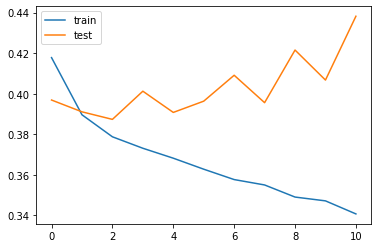

In [23]:
from sklearn.metrics import accuracy_score

# kNN
pred = knn_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('kNN Test accuracy: %.3f' % ( test_acc))

# Naive Bayes
pred = nb_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('Naive Bayes Test accuracy: %.3f' % ( test_acc))

# SVM
pred = svm_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('SVM Test accuracy: %.3f' % ( test_acc))

# DecisionTree
pred = dtree_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('DecisionTree Test accuracy: %.3f' % ( test_acc))

# RF
pred = rf_model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print('RF Test accuracy: %.3f' % ( test_acc))

# MLP
test_loss, test_acc = mlp_model.evaluate(x_test, y_test, verbose=0)
print('MLP Test accuracy: %.3f' % (test_acc))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Text(0.5, 15.0, 'y_pred')

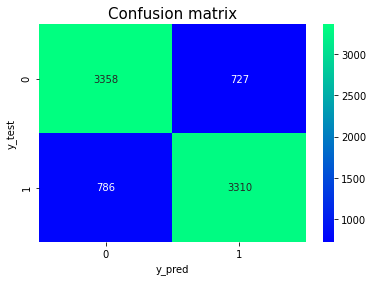

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = mlp_model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix, annot=True, fmt='3.0f', cmap="winter")
plt.title('Confusion matrix', y=1.05, size=15)
plt.ylabel('y_test')
plt.xlabel('y_pred')

## Most important features

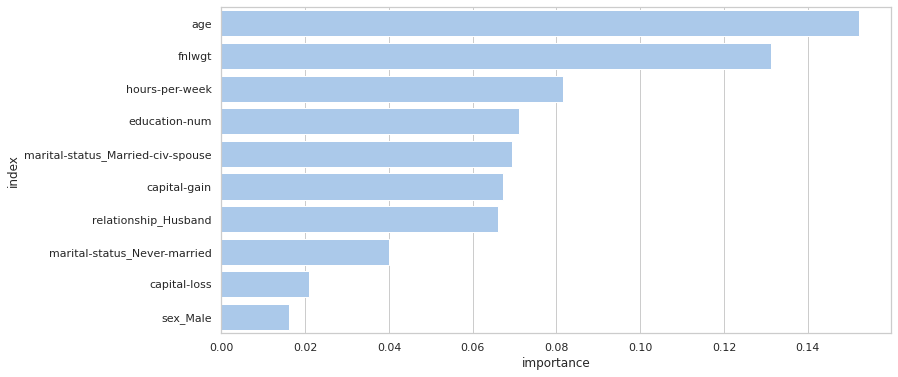

In [25]:
columns = norm_df.columns[:-2]
train = pd.DataFrame(np.atleast_2d(x_train), columns=columns)

feat_impts = []
for clf in rf_model.estimators_:
    feat_impts.append(clf.feature_importances_)
feature_importances = pd.DataFrame(np.mean(feat_impts, axis=0), 
                                   index = train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 6))

sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances[0:10],
            label="Total", color="b")

## Build, Train and save a simple model for future predictions

In [26]:
# Create Train, Test and Val data
simple_names = ['age', 'fnlwgt', 'hours-per-week', 'education-num']
for subname in ['marital-status_', 'relationship_']:
  simple_names += [name for name in norm_df.columns if subname in name]

X = norm_df[simple_names].to_numpy()
Y = pd.to_numeric(df['salary']
                  .str.replace('<=50K', '0').replace('>50K', '1')).to_numpy()
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)
print("Training X shape: " + str(x_train.shape))
print("Training Y shape: " + str(y_train.shape))
print("Test X shape: " + str(x_test.shape))
print("Test Y shape: " + str(y_test.shape))

X shape: (23374, 17)
Y shape: (23374,)
Training X shape: (15193, 17)
Training Y shape: (15193,)
Test X shape: (8181, 17)
Test Y shape: (8181,)


In [27]:
# Build MLP
x_shape, y_shape = X.shape[1], 1
mean_shape = (x_shape + y_shape) // 2

mlp_model = Sequential()
mlp_model.add(Dense(x_shape, input_shape=(x_shape,), activation='relu'))
mlp_model.add(Dense(mean_shape, activation='relu'))
mlp_model.add(Dense(y_shape, activation='sigmoid'))
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 17)                306       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 162       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 10        
Total params: 478
Trainable params: 478
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit MLP
history = mlp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10000, callbacks=[es], batch_size=1, verbose=2)

Epoch 1/10000
15193/15193 - 18s - loss: 0.4485 - accuracy: 0.7910 - val_loss: 0.4243 - val_accuracy: 0.8063
Epoch 2/10000
15193/15193 - 18s - loss: 0.4298 - accuracy: 0.8003 - val_loss: 0.4342 - val_accuracy: 0.8037
Epoch 3/10000
15193/15193 - 18s - loss: 0.4285 - accuracy: 0.7981 - val_loss: 0.4259 - val_accuracy: 0.8081
Epoch 4/10000
15193/15193 - 18s - loss: 0.4270 - accuracy: 0.8029 - val_loss: 0.4214 - val_accuracy: 0.8100
Epoch 5/10000
15193/15193 - 18s - loss: 0.4267 - accuracy: 0.8038 - val_loss: 0.4245 - val_accuracy: 0.8063
Epoch 6/10000
15193/15193 - 18s - loss: 0.4251 - accuracy: 0.8025 - val_loss: 0.4244 - val_accuracy: 0.8081
Epoch 7/10000
15193/15193 - 18s - loss: 0.4261 - accuracy: 0.8029 - val_loss: 0.4236 - val_accuracy: 0.8080
Epoch 8/10000
15193/15193 - 19s - loss: 0.4247 - accuracy: 0.8022 - val_loss: 0.4238 - val_accuracy: 0.8076
Epoch 9/10000
15193/15193 - 18s - loss: 0.4249 - accuracy: 0.8028 - val_loss: 0.4256 - val_accuracy: 0.8064
Epoch 00009: early stopping


MLP Test accuracy: 0.806


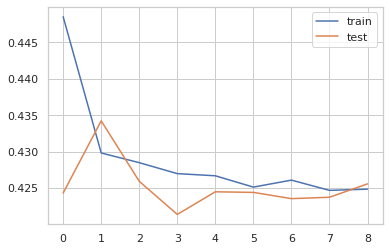

In [29]:
# Evaluate MLP
test_loss, test_acc = mlp_model.evaluate(x_test, y_test, verbose=0)
print('MLP Test accuracy: %.3f' % (test_acc))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
# Save weights
model_json = mlp_model.to_json()
with open("mlp_model.json", "w") as json_file:
    json_file.write(model_json)
mlp_model.save_weights("mlp_model.h5")
print("MLP model saved to the disk!")

MLP model saved to the disk!


## Try to predict using model

In [31]:
from keras.models import model_from_json

# Load model
json_file = open('mlp_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
mlp_model = model_from_json(loaded_model_json)
mlp_model.load_weights("mlp_model.h5")
print("MLP model loaded from the disk!")

mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model.summary()

MLP model loaded from the disk!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 17)                306       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 162       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 10        
Total params: 478
Trainable params: 478
Non-trainable params: 0
_________________________________________________________________


In [32]:
#@title Input your data { run: "auto" }
age =  35#@param {type:"integer"}
hours_per_week = 45 #@param {type:"integer"}
education_num =  14#@param {type:"integer"}
relationship = "Husband" #@param ['Unmarried', 'Not-in-family', 'Other-relative', 'Own-child', 'Wife', 'Husband']
marital_status = "Married-AF-spouse" #@param ['Separated', 'Married-AF-spouse', 'Divorced', 'Never-married', 'Married-spouse-absent', 'Widowed', 'Married-civ-spouse']
fnlwgt = df.loc[df['age'] == age]
fnlwgt = df["fnlwgt"].mean() if fnlwgt.empty else fnlwgt["fnlwgt"].mean()

sample_data = pd.DataFrame([[age, fnlwgt, hours_per_week, education_num, marital_status, relationship]],
                           columns=["age", "fnlwgt", "hours-per-week", "education-num", "marital-status", "relationship"])

# Normalize data
norm_sample_data = pd.DataFrame([[age, fnlwgt, hours_per_week, education_num] + [0 for _ in range(13)]],
                           columns=['age', 'fnlwgt', 'hours-per-week', 'education-num', 
                                    'marital-status_Divorced', 'marital-status_Married-AF-spouse',
                                    'marital-status_Married-civ-spouse',
                                    'marital-status_Married-spouse-absent', 'marital-status_Never-married',
                                    'marital-status_Separated', 'marital-status_Widowed',
                                    'relationship_Husband', 'relationship_Not-in-family',
                                    'relationship_Other-relative', 'relationship_Own-child',
                                    'relationship_Unmarried', 'relationship_Wife'])
for feature_name in sample_data.columns:
  if norm_map[feature_name] == "normalization":
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    norm_sample_data[feature_name] = (sample_data[feature_name] - min_value) / (max_value - min_value)
  if norm_map[feature_name] == "standartization":
    mean_value = df[feature_name].mean()
    std_value = df[feature_name].std()
    norm_sample_data[feature_name] = (sample_data[feature_name] - mean_value) / std_value
norm_sample_data["marital-status_" + marital_status] = 1
norm_sample_data["relationship_" + relationship] = 1
print("Normalized data:\n", norm_sample_data)

# Predict
pred = np.reshape(mlp_model.predict(norm_sample_data.to_numpy()), (sample_data.shape[0], 1))
print("\nNormalized salary:\n", pred)

# Show result dataframe
sample_data["salary"] = pd.Series(['<=50K' if row[0] <= 0.5 else '>50K' for row in pred], index=sample_data.index)
sample_data

Normalized data:
         age    fnlwgt  ...  relationship_Unmarried  relationship_Wife
0 -0.430566  0.125045  ...                       0                  0

[1 rows x 17 columns]

Normalized salary:
 [[0.97066903]]


,age,fnlwgt,hours-per-week,education-num,marital-status,relationship,salary
0,35,194042.483771,45,14,Married-AF-spouse,Husband,>50K
